Las cuatro redes de proteínas de levadura que
disponemos: Y2H, AP-MS, LIT y Lit-Reguly. Las dos últimas son redes construidas a partir de
interacciones reportadas en la literatura. 

In [1]:
#librerias a utilizar
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
import os
import scipy.stats as scipy
import random

In [2]:
#Para abrir archivos
def abrir_txt(nombre_archivo):
    archivo=open(nombre_archivo)
    data=[]
    for linea in archivo:
        linea=linea.strip()
        columna=linea.split()
        data.append(columna)
    if os.path.basename(nombre_archivo) == 'yeast_LIT_Reguly.txt':
        data = data[1:]
        enlaces = []
        for linea in data:
            enlaces.append(linea[:2])
        return(enlaces)
    if os.path.basename(nombre_archivo) == 'Essential_ORFs_paperHe.txt': 
        data = data[2:]
        esenciales = []
        for linea in data:
            if len(linea)>2:
                esenciales.append(linea[1])
        return esenciales
    else:
        return data

def crear_redes(red):
    lista_de_enlaces = abrir_txt(red)
    Red = nx.Graph()
    Red.add_edges_from(lista_de_enlaces)
    return Red

In [3]:
redes = {'Y2H': './data/yeast_Y2H.txt', 
         'AP_MS': './data/yeast_AP-MS.txt',
         'Lit': './data/yeast_LIT.txt',
         'Lit_reg': "./data/yeast_LIT_Reguly.txt"
         }
redes_dict = {}

for red in redes:
    grafo = crear_redes(redes[red])
    redes_dict[red] = {}
    redes_dict[red]["Grafo"] = grafo

# Tabla 1

In [4]:
def get_red_info(nombre_red):
    
    red = redes_dict[nombre_red]
    grafo = red['Grafo']
    red['Nodos'] = grafo.number_of_nodes() 
    red['Enlaces'] = grafo.number_of_edges()
    red['Grado medio'] = 2 * red['Enlaces'] / red['Nodos']
    red['Clustering medio'] = nx.average_clustering(grafo)   

In [5]:
for red in redes_dict.keys():
    get_red_info(red)

In [7]:
import pandas as pd

redes_df = redes_dict.copy() #no modificar data
df = pd.DataFrame(redes_dict).transpose()
df_sin_grafo = df.drop(columns = ['Grafo'])
df_sin_grafo = df_sin_grafo.astype({'Clustering medio': float, 'Grado medio': float})
df_sin_grafo.round({'Clustering medio': 2, 'Grado medio': 2})

,Clustering medio,Enlaces,Grado medio,Nodos
Y2H,0.05,2930,2.90,2018
AP_MS,0.55,9070,11.18,1622
Lit,0.29,2925,3.81,1536
Lit_reg,0.26,11858,7.17,3307


# Tabla 2

In [8]:
nodos = {}
enlaces = {}

for red in redes_dict:
    Red_proteinas = redes_dict[red]['Grafo']
    #Guardo enlaces y nodos en un set para poder hacer comparaciones facilmente
    enlaces[red], nodos[red] = set(), set()
    for nodo in Red_proteinas.nodes(): nodos[red].add(nodo)
    #Como los enlaces son NO dirigidos, los ordeno los nodos del enlace antes de guardarlo
    for enlace in Red_proteinas.edges(): enlace=sorted(enlace);enlaces[red].add((enlace[0],enlace[1]))

In [9]:
overlap_dict = {}  
lista_redes = list(redes_dict.keys())
lista_redes

['Y2H', 'AP_MS', 'Lit', 'Lit_reg']

In [10]:
def intersection(dicts):
    for key in dicts.keys():
        overlap_dict[key] = {}
        overlap_dict[key][key] = 0
        a = dicts[key]
        lista = ('b', 'c', 'd')
        for red in dicts.keys():
            if red == key:
                overlap_dict[key][key] = 0 
            else:
                interseccion = a.intersection(dicts[red])
                overlap_dict[key][red] = len(interseccion) / len(a)
            
                           
intersection(enlaces)     

In [11]:
overlap_dict

{'Y2H': {'Y2H': 0,
  'AP_MS': 0.08873720136518772,
  'Lit': 0.08873720136518772,
  'Lit_reg': 0.163481228668942},
 'AP_MS': {'AP_MS': 0,
  'Y2H': 0.02866593164277839,
  'Lit': 0.14310915104740904,
  'Lit_reg': 0.27783902976846747},
 'Lit': {'Lit': 0,
  'Y2H': 0.08888888888888889,
  'AP_MS': 0.4437606837606838,
  'Lit_reg': 0.9777777777777777},
 'Lit_reg': {'Lit_reg': 0,
  'Y2H': 0.040394670264800134,
  'AP_MS': 0.21251475796930341,
  'Lit': 0.24118738404452691}}

In [11]:
enlaces_df = overlap_dict.copy() #no modificar data
df = pd.DataFrame(enlaces_df).transpose()
df = df.astype(float).round(3)
for red, _ in df.iterrows():
    df.loc[df[red] == 0, red] = '-'
df


,AP_MS,Lit,Lit_reg,Y2H
Y2H,0.089,0.089,0.163,-
AP_MS,-,0.143,0.278,0.029
Lit,0.444,-,0.978,0.089
Lit_reg,0.213,0.241,-,0.04


Esta tabla se lee "De los enlaces de Y2H un 8.9% de sus enlaces también está en AP MS".

Esto no lo pide, pero podriamos ponerlo. Lo mismo una tabla para nodos. 

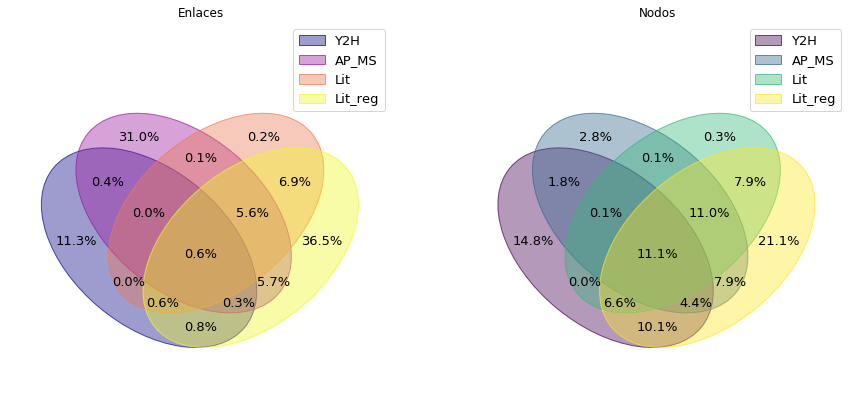

In [12]:
from venn import venn
f, axs = plt.subplots(1, 2 , figsize=(15,15))
venn_e = venn(enlaces, fmt="{percentage:.1f}%", ax= axs[0], cmap = "plasma")
axs[0].set_title("Enlaces")
venn(nodos, fmt="{percentage:.1f}%", ax= axs[1] )
axs[1].set_title("Nodos")
plt.show()

# Figura 1

In [7]:
lista_esenciales = abrir_txt('./data/Essential_ORFs_paperHe.txt')

grados_ordenados = {}

def segundo_lugar(item):
    return item[1]

for red in redes_dict.keys():
    grados_lista = list(redes_dict[red]['Grafo'].degree())
    grados_lista.sort(key = segundo_lugar, reverse = True)
    grados_ordenados[red] = grados_lista

In [14]:
from operator import itemgetter

def calcular_esenciales(red):
    
    nodos = list(map(itemgetter(0), grados_ordenados[red])) #lista de nodos ordenados por grado
    orden_grados = list(map(itemgetter(1), grados_ordenados[red])) #grados de dichos nodos
    
    hub_definition = []
    fraccion_hubs_esenciales = []

    for i in orden_grados: 
        lista_nodos = []
        for j in range(0,len(nodos)):
            if orden_grados[j] >= i: 
                lista_nodos.append(nodos[j]) #solo si tienen mayor grado
        
        hub_definition.append(len(lista_nodos) / redes_dict[red]['Nodos']) #propocion de nodos que tomo como hub
        hubs_esenciales = set(lista_nodos).intersection(lista_esenciales) #nodos esenciales dentro de los hubs
        fraccion_hubs_esenciales.append(len(hubs_esenciales) / len(lista_nodos) ) #fraccion entre los hubs de esenciales       
        
    return hub_definition, fraccion_hubs_esenciales

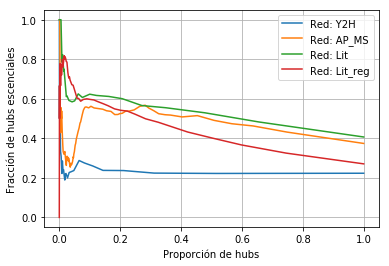

In [15]:
correlaciones = {}
for red in redes_dict.keys():
    x, y = calcular_esenciales(red)
    correlaciones[red] = {}
    correlaciones[red]['Kendall'] = scipy.kendalltau(x,y)[0]
    correlaciones[red]['Kendall p value'] = (scipy.kendalltau(x,y)[1])
    correlaciones[red]['Spearman'] = scipy.spearmanr(x,y)[0]
    correlaciones[red]['Spearman p value'] = scipy.spearmanr(x,y)[1]
    plt.plot(x, y, label = f'Red: {red}')
    plt.xlabel('Proporción de hubs')
    plt.ylabel('Fracción de hubs escenciales')
    plt.legend()
    

plt.grid()
plt.show()

In [16]:
correlaciones_df = correlaciones.copy() #no modificar data
df = pd.DataFrame(correlaciones_df).transpose()
df = df.astype(float).round(3)
df

,Kendall,Kendall p value,Spearman,Spearman p value
Y2H,-0.351,0.0,-0.448,0.0
AP_MS,-0.689,0.0,-0.693,0.0
Lit,-0.971,0.0,-0.994,0.0
Lit_reg,-0.995,0.0,-0.998,0.0


# Figura 3

Esto es igualito al ejercicio 2c del TPC_01.
Tenemos que considerar 7 centralidades:
* Remover nodos esenciales de una
* Random (ver código ya hecho)
* Eigenvalue: diccionario_centralidad_autovalor = nx.eigenvector_centrality(Red, max_iter=100, tol=1e-06, nstart=None, weight='weight')
* Degree centrality diccionario_centralidad_grado = nx.degree_centrality(Red)
* Shortest path diccionario_centralidad_intermediatez = nx.betweenness_centrality(Red, k=None, normalized=True, weight=None, endpoints=False, seed=None)
* current_flow 
* diccionario_centralidad_cercania = nx.closeness_centrality(Red, u=None, distance=None, wf_improved=True)
*

### 1) Esenciales

In [176]:
def sacar_esenciales(red, lista_esenciales):
    cant_nodos = redes_dict[red]['Nodos']
    Graph = redes_dict[red]['Grafo'].copy() #no modifico originales
    Graph.remove_nodes_from(lista_esenciales)
    fracc_nodos_sacados = 1 - Graph.number_of_nodes() / cant_nodos
      
    
    componentes=[Graph.subgraph(componente)
                 for componente in sorted(nx.connected_components(Graph),
                                          key=len, reverse=True)]
    gigante = componentes[0]
    fracc_tamamo_gigante = gigante.number_of_nodes() / cant_nodos
    return fracc_nodos_sacados, fracc_tamamo_gigante

Esto sólo para saber

In [177]:
nodos_esenciales_frac = {}
for red in redes_dict.keys():
    nodos_esenciales_frac[red] = len(set(redes_dict[red]["Grafo"].nodes()).intersection(lista_esenciales)) / redes_dict[red]['Nodos']

nodos_esenciales_frac

{'Y2H': 0.22348860257680872,
 'AP_MS': 0.37422934648581996,
 'Lit': 0.4069010416666667,
 'Lit_reg': 0.27094042939219837}

Ploteo para ir viendo, pero después hacemos toda una figura

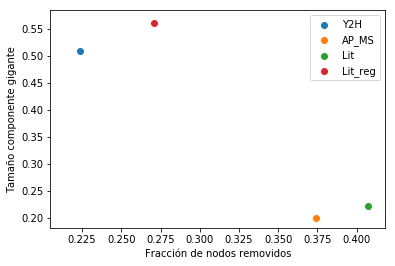

In [178]:
x_esen = {}
y_esen = {}

for red in redes_dict.keys():
    x_esen[red], y_esen[red] = sacar_esenciales(red, lista_esenciales)
    plt.scatter(x_esen[red], y_esen[red], label = f'{red}')

plt.xlabel("Fracción de nodos removidos")
plt.ylabel("Tamaño componente gigante")
plt.legend()
plt.show()

### 2) Random

In [21]:
def desarme_random(red):
    cant_nodos = redes_dict[red]['Nodos']
    tamano_gigante = np.array([])
    Red_rota_rand = redes_dict[red]['Grafo'].copy()
    nodes = list(Red_rota_rand.nodes)
    
    for node in nodes:
        Red_rota_rand.remove_node(node)
        componentes  = sorted(nx.connected_components(Red_rota_rand), 
                                                   key=len, reverse=True)
        
                        
        if len(componentes) >= 1:
            gigante = Red_rota_rand.subgraph(componentes[0]) 
            tamano_gigante = np.append(tamano_gigante, gigante.number_of_nodes() / cant_nodos )
            
    tamano = np.size(tamano_gigante)        
    tamano_gigante = np.pad(tamano_gigante, (0, cant_nodos - tamano ), 'constant')

    return tamano_gigante

In [22]:
import time

times = 2
i = 0
y_rand = {k: np.zeros(shape = redes_dict[k]["Nodos"]) for k in redes_dict.keys()}

while i < times:
    for red in redes_dict.keys():
        start = time.time()
        y_rand[red] = y_rand[red] + desarme_random(red)
        end = time.time()
        print(f'La red {red}_{i} tardó {round(end - start, 2)}s')
    i += 1

La red Y2H_0 tardó 3.92s
La red AP_MS_0 tardó 2.59s
La red Lit_0 tardó 2.51s
La red Lit_reg_0 tardó 12.59s
La red Y2H_1 tardó 3.71s
La red AP_MS_1 tardó 2.43s
La red Lit_1 tardó 2.14s
La red Lit_reg_1 tardó 11.21s


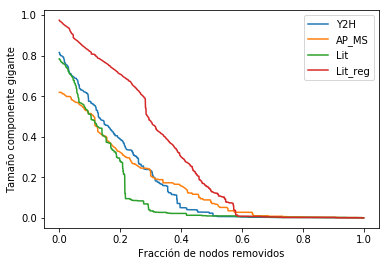

In [24]:
for red in y_rand.keys():
    y = y_rand[red] / times
    cant_nodos = redes_dict[red]['Nodos']
    x = [x / cant_nodos for x in range(0, len(y))]
    plt.plot(x,y, label = f'{red}')
    
plt.xlabel("Fracción de nodos removidos")
plt.ylabel("Tamaño componente gigante")
plt.legend()
plt.show()

### 3) Eigenvalue

In [25]:
import operator

def desarme_eigenvalue(red):
    centrality = nx.eigenvector_centrality(redes_dict[red]["Grafo"], max_iter=1000, tol=1e-03)

    tamano_gigante = []
    Red_rota = redes_dict[red]['Grafo'].copy()

    while Red_rota.number_of_nodes() > 1:
        node = max(centrality.items(), key=operator.itemgetter(1))[0]
        Red_rota.remove_node(node)
        
        #print(Red_rota.number_of_nodes())
        centrality = nx.eigenvector_centrality(Red_rota, max_iter=1000, tol=1e-03)
        componentes  = sorted(nx.connected_components(Red_rota), 
                                                   key=len, reverse=True)
                                       
        if len(componentes) >= 1:
            gigante = Red_rota.subgraph(componentes[0]) 
            tamano_gigante = np.append(tamano_gigante, gigante.number_of_nodes() / cant_nodos )
    
    tamano = np.size(tamano_gigante)        
    tamano_gigante = np.pad(tamano_gigante, (0, cant_nodos - tamano ), 'constant')

    return tamano_gigante

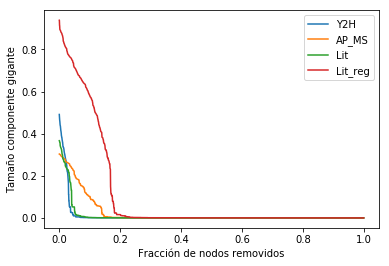

In [26]:
x_eigen = {}
y_eigen = {}

for red in redes_dict.keys():
    y_eigen[red] = desarme_eigenvalue(red)
    x_eigen[red] = [x / cant_nodos for x in range(0, len(y_eigen[red]))]
    plt.plot(x_eigen[red], y_eigen[red], label = f'{red}')

plt.xlabel("Fracción de nodos removidos")
plt.ylabel("Tamaño componente gigante")
plt.legend()
plt.show()

### 4) Degree

In [27]:
import operator

def desarme_degree(red):
    degree = nx.degree_centrality(redes_dict[red]["Grafo"])

    tamano_gigante = []
    Red_rota = redes_dict[red]['Grafo'].copy()

    while Red_rota.number_of_nodes() > 1:
        node = max(degree.items(), key=operator.itemgetter(1))[0]
        Red_rota.remove_node(node)
        
        #print(Red_rota.number_of_nodes())
        degree = nx.degree_centrality(Red_rota)
        componentes  = sorted(nx.connected_components(Red_rota), 
                                                   key=len, reverse=True)
                                       
        if len(componentes) >= 1:
            gigante = Red_rota.subgraph(componentes[0]) 
            tamano_gigante = np.append(tamano_gigante, gigante.number_of_nodes() / cant_nodos )
    
    tamano = np.size(tamano_gigante)        
    tamano_gigante = np.pad(tamano_gigante, (0, cant_nodos - tamano ), 'constant')

    return tamano_gigante

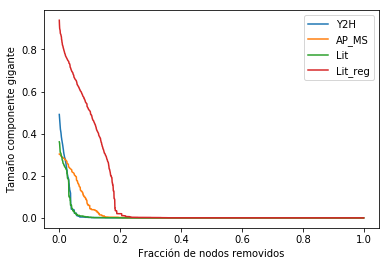

In [28]:
x_deg = {}
y_deg = {}

for red in redes_dict.keys():
    y_deg[red] = desarme_degree(red)
    x_deg[red] = [x / cant_nodos for x in range(0, len(y_deg[red]))]
    plt.plot(x_deg[red], y_deg[red], label = f'{red}')

plt.xlabel("Fracción de nodos removidos")
plt.ylabel("Tamaño componente gigante")
plt.legend()
plt.show()

### 5) Betweeness

In [29]:
import operator

def desarme_bet(red):
    k = 20
    bet = nx.betweenness_centrality(redes_dict[red]["Grafo"], k = k)

    tamano_gigante = []
    Red_rota = redes_dict[red]['Grafo'].copy()

    while Red_rota.number_of_nodes() > k:
        node = max(bet.items(), key=operator.itemgetter(1))[0]
        Red_rota.remove_node(node)
       
        bet = nx.betweenness_centrality(Red_rota, k = k)
        componentes  = sorted(nx.connected_components(Red_rota), 
                                                   key=len, reverse=True)
                                       
        if len(componentes) >= 1:
            gigante = Red_rota.subgraph(componentes[0]) 
            tamano_gigante = np.append(tamano_gigante, gigante.number_of_nodes() / cant_nodos )
    
    tamano = np.size(tamano_gigante)        
    tamano_gigante = np.pad(tamano_gigante, (0, cant_nodos - tamano ), 'constant')

    return tamano_gigante

La red Y2H tardó 26.58s
La red AP_MS tardó 13.19s
La red Lit tardó 11.69s
La red Lit_reg tardó 102.29s


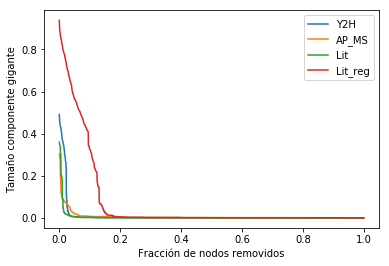

In [30]:
x_bet = {}
y_bet = {}

for red in redes_dict.keys():
    start = time.time()
    y_bet[red] = desarme_bet(red)
    end = time.time()
    print(f'La red {red} tardó {round(end - start, 2)}s')
    x_bet[red] = [x / cant_nodos for x in range(0, len(y_bet[red]))]
    plt.plot(x_bet[red], y_bet[red], label = f'{red}')

plt.xlabel("Fracción de nodos removidos")
plt.ylabel("Tamaño componente gigante")
plt.legend()
plt.show()

### 6) Closeness

In [31]:
import igraph as ig

def close_ig(red):
    G_ig = ig.Graph(directed=True)
    G_ig.add_vertices(list(red.nodes()))
    G_ig.add_edges(list(red.edges()))
    conectado = G_ig.components()[0]
    component = G_ig.subgraph(conectado)
    closeness = component.closeness(vertices=None, mode='ALL', cutoff=None, weights=None, normalized=True)
    keys = list(red.nodes())
    close_dict = dict(zip(keys, closeness))
    return close_dict



In [32]:
import operator

def desarme_close(red):

    close = close_ig(redes_dict[red]['Grafo'])
       
    tamano_gigante = []
    Red_rota = redes_dict[red]['Grafo'].copy()
    
    i = 0
    size_gigante = redes_dict[red]['Nodos']
    
    while 1 <  Red_rota.number_of_nodes():
        node = max(close.items(), key=operator.itemgetter(1))[0]
        Red_rota.remove_node(node)

        close = close_ig(Red_rota)
        componentes = sorted(nx.connected_components(Red_rota), key=len, reverse=True)
        i += 1                                                   
                                       
        if len(componentes) >= 1:
            gigante = Red_rota.subgraph(componentes[0])
            size_gigante = gigante.number_of_nodes()
            tamano_gigante = np.append(tamano_gigante, size_gigante / cant_nodos )
    
    tamano = np.size(tamano_gigante)        
    tamano_gigante = np.pad(tamano_gigante, (0, cant_nodos - tamano ), 'constant')

    return tamano_gigante 
     

La red Y2H tardó 7.95s
La red AP_MS tardó 5.84s
La red Lit tardó 4.03s
La red Lit_reg tardó 24.31s


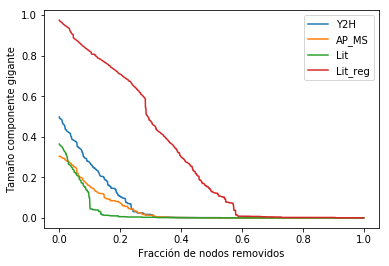

In [33]:
x_clos = {}
y_clos = {}

for red in redes_dict.keys():
    start = time.time()
    y_clos[red] = desarme_close(red)
    end = time.time()
    print(f'La red {red} tardó {round(end - start, 2)}s')
    x_clos[red] = [x / cant_nodos for x in range(0, len(y_clos[red]))]
    plt.plot(x_clos[red], y_clos[red], label = f'{red}')

plt.xlabel("Fracción de nodos removidos")
plt.ylabel("Tamaño componente gigante")
plt.legend()
plt.show()

# En un plot para cada una

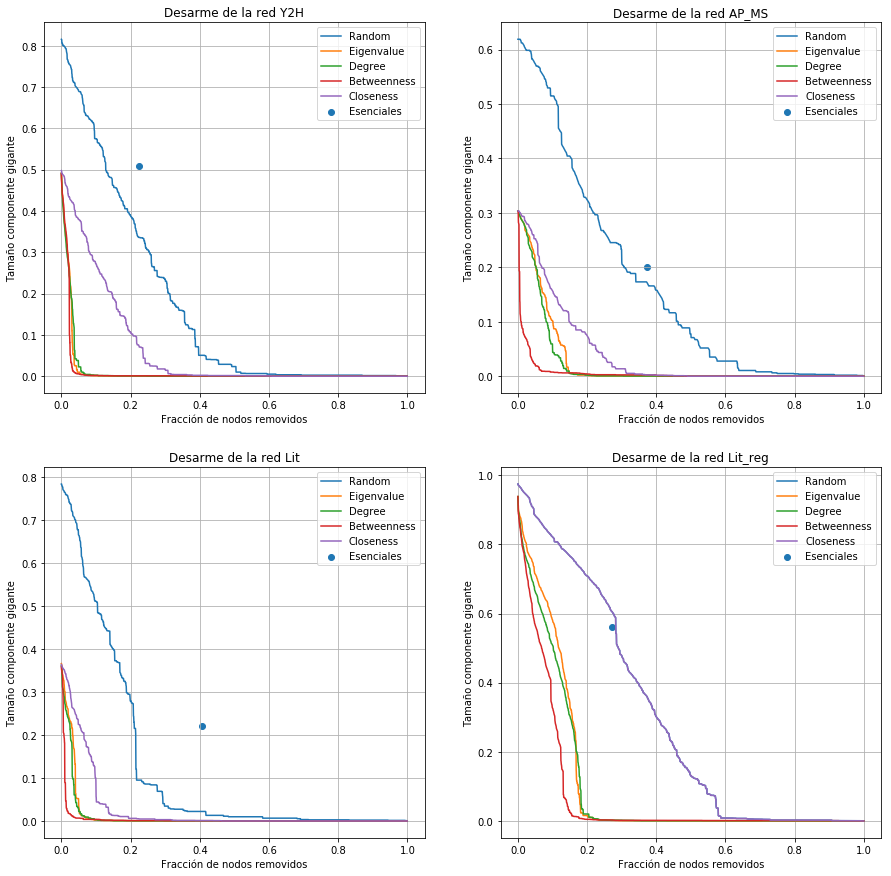

In [36]:
f, ax = plt.subplots(2, 2, figsize=(15,15))
ax = ax.flatten()

for i,red in enumerate(redes_dict.keys()):
#esen
    ax[i].scatter(x_esen[red], y_esen[red], label = 'Esenciales')

#rand
    y = y_rand[red] / times
    cant_nodos = redes_dict[red]['Nodos']
    x = [x / cant_nodos for x in range(0, len(y))]
    
    ax[i].plot(x, y, label = 'Random')
    
#eigen
    ax[i].plot(x_eigen[red], y_eigen[red], label = 'Eigenvalue')

#degree
    ax[i].plot(x_deg[red], y_deg[red], label = 'Degree')

#Betweenness
    ax[i].plot(x_bet[red], y_bet[red], label = 'Betweenness')

#Closeness
    ax[i].plot(x_clos[red], y_clos[red], label = 'Closeness')

    ax[i].legend()
    ax[i].set_title(f'Desarme de la red {red}')
    ax[i].set_xlabel("Fracción de nodos removidos")
    ax[i].set_ylabel("Tamaño componente gigante")
    ax[i].grid()
plt.savefig(f'fig_3.png')
plt.show()

## Tabla 3

In [8]:
esenciales_grado = {}
for red in redes_dict.keys():
    grafo = redes_dict[red]["Grafo"]
    esenciales_en_red = set(grafo.nodes()).intersection(lista_esenciales)
    esenciales_grado[red] = {}
    for node in esenciales_en_red:
        esenciales_grado[red][node] = nx.degree(grafo, node)

In [338]:
def simil_esenciales(red):

    nodos_a_sacar = []
    nodos_equivalente = []
    nodos_sin_equivalente = []

    nodos_esenciales = esenciales_grado[red]
    grafo = redes_dict[red]["Grafo"]
    d = dict(grafo.degree())
    l = list(d.items())
    random.shuffle(l)
    d = dict(l)


    for node, degree in nodos_esenciales.items():
        for (u,v) in d.items():
            if degree == v and not u in nodos_a_sacar and not u in nodos_esenciales.keys():
                nodos_a_sacar.append(u)
                nodos_equivalente.append(node)
                break

    faltan = set(nodos_esenciales.keys()).difference(set(nodos_equivalente))
    for nodo in faltan:
        nodos_sin_equivalente.append(nodo)

    return nodos_a_sacar + nodos_sin_equivalente

In [341]:
def random_same_degree(red):
    nodos_a_sacar = []

    nodos_esenciales = esenciales_grado[red]
    grafo = redes_dict[red]["Grafo"]
    d = dict(grafo.degree())
    l = list(d.items())
    random.shuffle(l)
    d = dict(l)


    for node, degree in nodos_esenciales.items():
        for (u,v) in d.items():
            if degree == v and not u in nodos_a_sacar:
                nodos_a_sacar.append(u)
                break
                
    return nodos_a_sacar

In [347]:
cg_rand= {k: [] for k in redes_dict.keys()}
cg_simil = {k: [] for k in redes_dict.keys()}

times = 100
i = 0

while i < times:
    for red in redes_dict.keys():
        nodos_a_sacar_simil = simil_esenciales(red)
        _ , tamano_cg_simil = sacar_esenciales(red, nodos_a_sacar_simil)
        cg_simil[red].append(tamano_cg_simil)
        
        nodos_a_sacar_rand = random_same_degree(red)
        _ , tamano_cg_rand = sacar_esenciales(red, nodos_a_sacar_rand)
        cg_rand[red].append(tamano_cg_rand)
        
    i += 1



In [348]:
x_esen = {}
y_esen = {}

y_simil = {}
simil_error = {}
y_rand = {}
rand_error = {}

for red in redes_dict.keys():
    y_simil[red] = np.array(cg_simil[red]).mean()
    simil_error[red] = np.array(cg_simil[red]).std()
    
    y_rand[red] = np.array(cg_rand[red]).mean()
    rand_error[red] = np.array(cg_rand[red]).std()
      
    grafo = redes_dict[red]["Grafo"]
    esenciales_en_red = set(grafo.nodes()).intersection(lista_esenciales)
    x_esen[red], y_esen[red] = sacar_esenciales(red, esenciales_en_red)

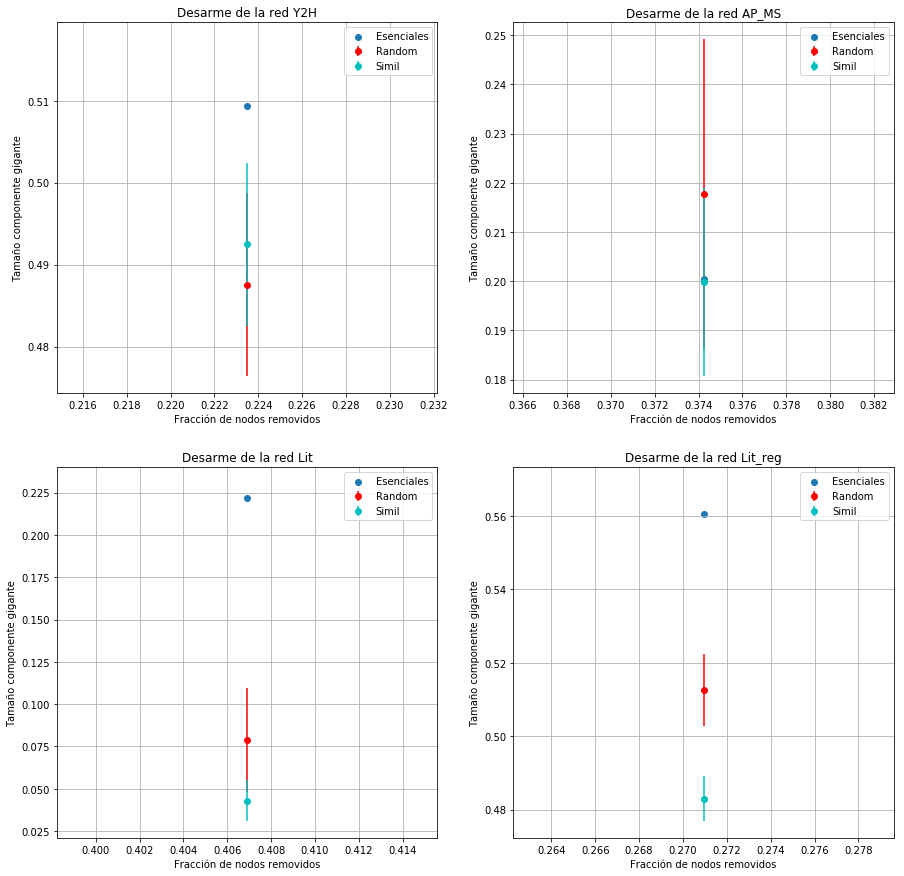

In [349]:
f, ax = plt.subplots(2, 2, figsize=(15,15))
ax = ax.flatten()

for i,red in enumerate(redes_dict.keys()):
#esen
    ax[i].scatter(x_esen[red], y_esen[red], label = 'Esenciales')

#rand
    ax[i].errorbar(x_esen[red], y_rand[red], yerr = rand_error[red], fmt = 'ro', label = 'Random')
    
    ax[i].errorbar(x_esen[red], y_simil[red], yerr = simil_error[red], fmt = 'co', label = 'Simil')


    ax[i].legend()
    ax[i].set_title(f'Desarme de la red {red}')
    ax[i].set_xlabel("Fracción de nodos removidos")
    ax[i].set_ylabel("Tamaño componente gigante")
    ax[i].grid()
plt.savefig(f'tabla_3.png')
plt.show()

# acá falta hacer una tabla con los valores
los valores están en los dics de y (rand y simil) y sus errores (simil y rand)


Veamos la otra figura 2b. Primero veo cuantos esenciales hay por grado y cuantos nodos hay por grado.

In [47]:
def cantidad_por_grado(dictionary, new_dict):
    for pair in dictionary.items():
        if pair[1] not in new_dict.keys():
            new_dict[pair[1]] = 0
        new_dict[pair[1]] += 1   

esenciales_por_grado = {}
nodos_por_grado = {}

for red in redes_dict.keys():
    esenciales_por_grado[red] = {}
    new_dict = esenciales_por_grado[red]
    cantidad_por_grado(esenciales_grado[red], new_dict)
    
    grados = dict(redes_dict[red]['Grafo'].degree())
    nodos_por_grado[red] = {}
    new_dict = nodos_por_grado[red]
    cantidad_por_grado(grados, new_dict)

In [152]:
probabilidad_esencial = {}
for red in redes_dict.keys():
    probabilidad_esencial[red] = {}
    for grado in nodos_por_grado[red].keys():
        esencial = esenciales_por_grado[red].get(grado)
        if esencial:
            probabilidad_esencial[red][grado] =  esencial / nodos_por_grado[red][grado]

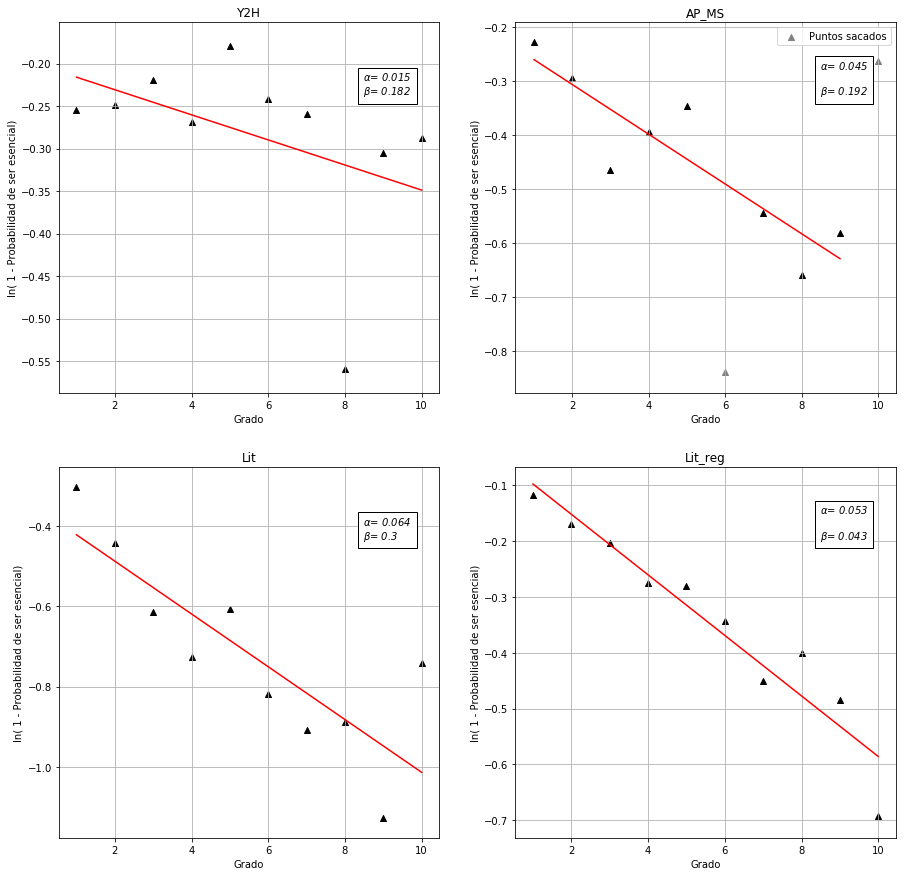

In [158]:
alfa = {}
beta = {}

your_keys = list(range(1,11))
ap_keys = list(range(1,6)) + list(range(7, 10))

f, ax = plt.subplots(2, 2, figsize=(15,15))
ax = ax.flatten()

for i,red in enumerate(redes_dict.keys()):
    if red == "AP_MS":
        dict_you_want = {your_key: probabilidad_esencial[red][your_key] for your_key in ap_keys}
        sacados = {6: probabilidad_esencial[red][6], 10: probabilidad_esencial[red][10]}
        x_sacados = list(sacados.keys())
        pe_sacados = list(sacados.values())
        y_sacados = [np.log(1 - pe) for pe in pe_sacados]
        ax[i].scatter(x_sacados, y_sacados, marker = "^", color = 'grey', label = "Puntos sacados")
        ax[i].legend()
    else:
        dict_you_want = {your_key: probabilidad_esencial[red][your_key] for your_key in your_keys}
    
    x = list(dict_you_want.keys())
    pe = list(dict_you_want.values())
    y = [np.log(1 - pe) for pe in pe]
    ax[i].scatter(x, y, marker = "^", color = 'black') 
         
    ajuste, cov = np.polyfit(x, y, 1, cov = True)
    error = np.sqrt(cov[1][1])
    lineal = np.poly1d(ajuste)
    ax[i].plot(x, lineal(x), color = "red")
    alfa[red] = 1 - np.exp(lineal[1])
    beta[red] = 1 - np.exp(lineal[0])
    t = (r"$\alpha$" f"= {round(1 - np.exp(lineal[1]), 3)} \n" r" $\beta$" f"= {round(1 - np.exp(lineal[0]), 3)}")
    ax[i].text(0.8, 0.8, t , style='italic', bbox={'facecolor': 'white', 'alpha': 1, 'pad': 5}, transform=ax[i].transAxes, wrap = True )
    
    
    
    ax[i].set_title(f'{red}')
    #ax[i].legend()
    ax[i].set_xlabel("Grado")
    ax[i].set_ylabel("ln( 1 - Probabilidad de ser esencial)")
    ax[i].grid()

plt.savefig("2b.png")
plt.show()


# Con Y2H no es posible este método. Hay que ver si hice bien las cuentas de alpha y beta. Para Ap es falopa. Saqué el grado 6 y 10 porque daban raros. 

# Tabla 5

### Line fitting

In [ ]:
line_fitting = {}
for red in redes_dict.keys():
    pe = 1 - (1 - beta[red]) * (1 - alfa[red]) ** k #que es esa k aca hay que hacerlo para cada grado?
    line_fitting[ŕed] = pe **2 + (1 - pe)**2

In [219]:
vecinos = {}
for red in redes_dict.keys():
    vecinos[red] = {}
    grafo = redes_dict[red]['Grafo']
    for node in grafo.nodes():
        vecinos[red][node] = set([n for n in redes_dict[red]['Grafo'].neighbors(node)])

In [223]:
pares = {}
for red in redes_dict.keys():
    pares[red] = 0
    nodos = list(vecinos[red].keys())
    for nodo in nodos:
        for otro_nodo in nodos:
            if not otro_nodo == nodo:
                vecino = vecinos[red][nodo]
                otros_vecinos = vecinos[red][otro_nodo]
                if len(vecino.intersection(otros_vecinos)) >= 2:
                    ambos_esenciales = otro_nodo in lista_esenciales and nodo in lista_esenciales
                    ambos_no_esenciales = otro_nodo not in lista_esenciales and nodo not in lista_esenciales
                    if ambos_esenciales or ambos_no_esenciales:
                        pares[red] += 1
        nodos.remove(otro_nodo)
    print("Termine!")
        

Termine!
Termine!
Termine!
Termine!


In [224]:
pares

{'Y2H': 2610, 'AP_MS': 21144, 'Lit': 3153, 'Lit_reg': 36063}

In [203]:
redes_dict

{'Y2H': {'Grafo': <networkx.classes.graph.Graph at 0x7f106b4e14a8>,
  'Nodos': 2018,
  'Enlaces': 2930,
  'Grado medio': 2.9038652130822595,
  'Clustering medio': 0.046194001297365166},
 'AP_MS': {'Grafo': <networkx.classes.graph.Graph at 0x7f106b480e48>,
  'Nodos': 1622,
  'Enlaces': 9070,
  'Grado medio': 11.183723797780518,
  'Clustering medio': 0.5546360657013013},
 'Lit': {'Grafo': <networkx.classes.graph.Graph at 0x7f106b038320>,
  'Nodos': 1536,
  'Enlaces': 2925,
  'Grado medio': 3.80859375,
  'Clustering medio': 0.2924923005815711},
 'Lit_reg': {'Grafo': <networkx.classes.graph.Graph at 0x7f106b25ec88>,
  'Nodos': 3307,
  'Enlaces': 11858,
  'Grado medio': 7.17145449047475,
  'Clustering medio': 0.2611335815481772}}